<a href="https://colab.research.google.com/github/sanelemahlalela/changelogtest/blob/master/se_demand_planner_supplier_portal_products.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats

from datetime import datetime, timedelta
from pandas import DataFrame, Series
from sklearn.metrics import mean_squared_error

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
project_id = 'dh-darkstores-live'

In [ ]:
# define some variables
run_date = datetime.now()
country_code = 'se'
forecast_version = 'v2'
availability_days = 28
target_service_level = 0.90
z_score = stats.norm.ppf(target_service_level)

warehouse_id = '87d47f17-25cc-4e89-9bbc-3df289eba49d'  #  sample prototype warehouse_id. Name (Östermalm)
supplier_ids_to_exclude = 25 # https://jira.deliveryhero.com/browse/DATABUY-558?focusedCommentId=2987949&page=com.atlassian.jira.plugin.system.issuetabpanels%3Acomment-tabpanel#comment-2987949

In [ ]:
z_score

1.2815515655446004

### Define input queries

In [ ]:
product_config_query = f"""

WITH products AS (
SELECT p.country_code
, p.sku
, p.product_name
, p.barcodes
, w.warehouse_name
, w.warehouse_id
, MAX(COALESCE(v.sales_buffer,0)) as sales_buffer
, MAX(v.is_active) as is_active
FROM `fulfillment-dwh-production.cl_dmart.products_v2` p
, UNNEST(warehouse_info) as w
, UNNEST(w.vendor_info) AS v
WHERE w.is_dmart = TRUE
AND v.is_active = TRUE
AND country_code ='se'
AND warehouse_id = '87d47f17-25cc-4e89-9bbc-3df289eba49d'
GROUP BY 1,2,3,4,5,6
),
-- supplier information
active_sku_suppliers AS (
SELECT country_code
,sku
,sp.supplier_id
,sp.supplier_name
,sp.min_qty
,sp.preference
,sp.is_preferred
,sp.is_preferred_relex
,sp.is_dc
,wh.warehouse_id
,wh.trade_cost
FROM `fulfillment-dwh-production.cl_dmart.products_suppliers` AS pr
,UNNEST(suppliers) AS sp
,UNNEST(sp.warehouses) AS wh
WHERE wh.warehouse_id IS NOT NULL
AND supplier_id <> 25 -- exclude store transfers
AND country_code ='se'
AND warehouse_id = '87d47f17-25cc-4e89-9bbc-3df289eba49d'
AND sp.preference = 1
AND sp.is_preferred = TRUE
),
-- stock and PO data
last_po AS (
SELECT country_code
,warehouse_id
,pp.sku_id sku
,DATE(pp.receiving_localtime_at) latest_delivery_date
,pp.quantity_ordered last_po_order_qty
,pp.quantity_delivered last_po_delivered_qty
,pp.quantity_delivered/pp.quantity_ordered last_po_fill_rate
,pp.expiration_date
,DATE_DIFF(pp.expiration_date, DATE(pp.receiving_localtime_at),DAY) AS days_to_expiration
FROM `fulfillment-dwh-production.cl_dmart.purchase_orders`
, UNNEST(products_purchased) AS pp
  WHERE
    country_code = 'se'
    AND pp.order_is_done = TRUE
QUALIFY ROW_NUMBER() OVER(PARTITION BY warehouse_id, sku_id ORDER BY pp.receiving_localtime_at DESC)  = 1
),
stock_on_hand AS ( -- latest cumulative stock per sku-wh
SELECT country_code
, s.movement_localtime_at AS on_hand_stock_date
, product.sku
, product.is_product_active
, warehouse.warehouse_id
, s.cumulative_quantity
, ROW_NUMBER() OVER (PARTITION BY country_code, product.sku, warehouse.warehouse_id ORDER by s.movement_at desc) as latest
FROM `fulfillment-dwh-production.cl_dmart.stock_movement`
, UNNEST (stock_movement_data) s
WHERE warehouse.is_dmart = TRUE
-- AND product.is_product_active = TRUE
AND country_code ='se'
AND warehouse_id = '87d47f17-25cc-4e89-9bbc-3df289eba49d'
QUALIFY latest = 1
),
stock_in_transit AS (
SELECT po.country_code
,po.warehouse_id
,p.sku_id AS sku
,MAX(po.created_localtime_at) AS in_transit_stock_date
,SUM(CASE WHEN p.receiving_at is null AND p.quantity_delivered is null THEN p.quantity_ordered ELSE 0 END) AS stock_in_transit
FROM `fulfillment-dwh-production.cl_dmart.purchase_orders` po
, UNNEST (products_purchased) p
WHERE order_status = 'confirmed'
AND country_code ='se'
AND warehouse_id = '87d47f17-25cc-4e89-9bbc-3df289eba49d'
GROUP BY 1,2,3
),
transfers AS (
WITH transfer_raw AS(
SELECT st.country_code
, st.src_warehouse_id
, st.dest_warehouse_id
, p.sku
, p.requested_qty
FROM  `fulfillment-dwh-production.cl_dmart.store_transfers` st
, UNNEST(status_history) AS s
, UNNEST(products) AS p
WHERE status NOT IN ('COMPLETED', 'CANCELED')
AND country_code = 'se'
QUALIFY ROW_NUMBER() OVER(PARTITION BY st.country_code, st.external_id ORDER BY st.modified_at DESC) = 1
)
SELECT country_code
, src_warehouse_id
, dest_warehouse_id
, sku
, SUM(requested_qty) AS requested_qty
FROM transfer_raw
GROUP BY 1, 2, 3, 4
),
-- availability & sales
grouped_availability AS (
    SELECT country_code
    , sd.warehouse_id
    , sku
    , SUM(CASE WHEN h.is_available_hourly IS TRUE THEN 1 ELSE 0 END) avail_hours
    FROM `fulfillment-dwh-production.cl_dmart._stock_daily` sd,  UNNEST(hourly) AS h
    WHERE stock_date > CURRENT_DATE() - (28 + 1)
    AND stock_date < CURRENT_DATE()
    AND lower(country_code) = 'se'
    AND warehouse_id = '87d47f17-25cc-4e89-9bbc-3df289eba49d'
    GROUP BY 1,2,3
),
daily_sales AS (
SELECT country_code
, warehouse.warehouse_id AS warehouse_id
, i.sku AS sku
, ROUND(avail_hours/(28 * 24), 2) AS availability
, SUM(CASE WHEN DATE(co.order_placed_localtime_at) > CURRENT_DATE(co.timezone)-28 THEN i.qty_sold ELSE 0 END) AS units_sold
, ROUND(AVG(CASE WHEN DATE(co.order_placed_localtime_at) > CURRENT_DATE(co.timezone)-28 THEN i.qty_sold ELSE 0 END),4) AS avg_units_sold
, SUM(CASE WHEN DATE(co.order_placed_localtime_at) > CURRENT_DATE(co.timezone)-7 THEN i.qty_sold ELSE 0 END) AS units_sold_7d
, ROUND(AVG(CASE WHEN DATE(co.order_placed_localtime_at) > CURRENT_DATE(co.timezone)-7 THEN i.qty_sold ELSE 0 END), 4) AS avg_units_sold_7d
    FROM `fulfillment-dwh-production.cl_dmart.customer_orders` co
    ,UNNEST(items) AS i
    LEFT JOIN grouped_availability USING(country_code, warehouse_id, sku)
    WHERE TRUE
    AND co.is_sent = True
    AND co.country_code = 'se'
    AND co.warehouse.warehouse_id = '87d47f17-25cc-4e89-9bbc-3df289eba49d'
    GROUP BY 1,2,3,4
)

-- main query
SELECT p.country_code
, p.sku
, p.product_name
, p.barcodes as barcode
, p.warehouse_name as store
, p.warehouse_id
, p.is_active
,sp.supplier_id
-- ,sp.supplier_name
,sp.min_qty
,sp.preference
,sp.trade_cost as trade_cost_lp
,lpo.latest_delivery_date
,lpo.last_po_order_qty
,lpo.last_po_delivered_qty
,lpo.last_po_fill_rate
,lpo.days_to_expiration
--,lpo.expiration_date --- TODO: FIX -- figure out issue with gbq reader
, CURRENT_DATE() AS expiration_date
,p.sales_buffer
,COALESCE(soh.cumulative_quantity,0) AS stock_on_hand
,soh.on_hand_stock_date
,COALESCE(sit.stock_in_transit,0) AS stock_in_transit
,sit.in_transit_stock_date
,COALESCE(soh.cumulative_quantity,0) - COALESCE(src_transfer.requested_qty,0) AS on_hand_minus_transfer_req
,COALESCE(dest_transfer.requested_qty,0) AS transfer_stock
,s.availability
,s.units_sold
,s.units_sold_7d
,s.avg_units_sold
FROM products p
LEFT JOIN active_sku_suppliers sp USING (country_code, sku, warehouse_id)
LEFT JOIN stock_on_hand soh USING (country_code, sku, warehouse_id)
LEFT JOIN stock_in_transit sit USING (country_code, sku, warehouse_id)
LEFT JOIN last_po lpo USING (country_code, sku, warehouse_id)
LEFT JOIN daily_sales s USING (country_code, sku, warehouse_id)
LEFT JOIN transfers src_transfer
   ON p.country_code     = src_transfer.country_code
   AND p.warehouse_id    = src_transfer.src_warehouse_id
   AND p.sku             = src_transfer.sku
LEFT JOIN transfers dest_transfer
   ON p.country_code     = dest_transfer.country_code
   AND p.warehouse_id    = dest_transfer.dest_warehouse_id
   AND p.sku             = dest_transfer.sku
"""

In [ ]:
schedule_query = f"""

SELECT * 
FROM `dh-darkstores-stg.dev_dmart.se_supplier_schedules_raw_v3` #temp table, will expire in 30 days
where supplier_id != {supplier_ids_to_exclude}
"""

In [ ]:
forecast_query = f"""

WITH
  actuals AS (
  SELECT
    warehouse.warehouse_id AS warehouse_id,
    i.sku AS sku,
    DATE(co.order_placed_localtime_at) AS order_date,
    SUM(i.qty_sold) AS units_sold
  FROM
    fulfillment-dwh-production.cl_dmart.customer_orders co,
    UNNEST(items) AS i
  WHERE
    TRUE
    AND co.is_sent = TRUE
    AND LOWER(co.country_code) = '{country_code}'
    AND DATE(co.order_placed_localtime_at) >= CURRENT_DATE() - {availability_days}
  GROUP BY
    1, 2, 3
    ),
  forecast AS (
  SELECT
    warehouse_id,
    order_date,
    sku,
    pred_units
  FROM
    `dh-darkstores-live.cl_data_science_qcommerce.demand_forecast_{forecast_version}`
  WHERE
    order_date >= CURRENT_DATE() - {availability_days}
    AND LOWER(country_code) = '{country_code}'
    )
SELECT DISTINCT #added distinct due to DATABUY-540 bug
  warehouse_id,
  sku,
  order_date,
  DATE_DIFF(order_date, CURRENT_DATE(), DAY) lookahead_from_today, #add local timezone 
  COALESCE(pred_units, 0) AS pred_units,
  SUM(CASE WHEN order_date >= CURRENT_DATE() THEN pred_units ELSE 0 END) OVER(PARTITION BY warehouse_id, sku ORDER BY order_date) cumulative_future_preds,
  COALESCE(units_sold, 0) AS units_sold
FROM
  forecast
FULL OUTER JOIN
  actuals
USING
  (warehouse_id, sku, order_date)


"""

### Get data

In [ ]:
product_config = pd.read_gbq(product_config_query, project_id=project_id, dialect='standard')

In [ ]:
product_config.head()

,country_code,sku,product_name,barcode,store,warehouse_id,is_active,supplier_id,min_qty,preference,trade_cost_lp,latest_delivery_date,last_po_order_qty,last_po_delivered_qty,last_po_fill_rate,days_to_expiration,expiration_date,sales_buffer,stock_on_hand,on_hand_stock_date,stock_in_transit,in_transit_stock_date,on_hand_minus_transfer_req,transfer_stock,availability,units_sold,units_sold_7d,avg_units_sold
0,se,65J117,Nocco Blueberry Winter Edition 330ml,7340131601428,foodora market Östermalm,87d47f17-25cc-4e89-9bbc-3df289eba49d,True,NaN,NaN,NaN,NaN,2020-12-01,240.0,240.0,1.0,148.0,2021-10-21,1,0,2021-03-30 21:39:33.312000,0,NaT,0,0,0.00,0,0,0
1,se,8930FB,Findus nFine fillets of cod MSC 375g,7310500184302,foodora market Östermalm,87d47f17-25cc-4e89-9bbc-3df289eba49d,True,7.0,11.0,1.0,4818.0,2021-10-06,11.0,11.0,1.0,452.0,2021-10-21,0,3,2021-10-20 09:19:39.465032,0,NaT,3,0,1.00,15,3,0.3261
2,se,YJJI4O,Greendeli Yoghurt Granola honung 210g,7350035639656,foodora market Östermalm,87d47f17-25cc-4e89-9bbc-3df289eba49d,True,34.0,1.0,1.0,1912.0,2021-10-20,2.0,2.0,1.0,6.0,2021-10-21,0,2,2021-10-20 07:32:19.354187,4,2021-10-20 10:18:02.271336,2,0,0.17,4,4,0.1081
3,se,L7CJE9,Ramlösa Citrus 330ml,"7310070004765,7310070766083",foodora market Östermalm,87d47f17-25cc-4e89-9bbc-3df289eba49d,True,7.0,20.0,1.0,344.0,2021-10-20,400.0,400.0,1.0,272.0,2021-10-21,1,556,2021-10-20 10:44:32.101852,0,NaT,556,0,1.00,1028,252,5.064
4,se,802VFE,Remi Mint Cookie 100g,7310525701416,foodora market Östermalm,87d47f17-25cc-4e89-9bbc-3df289eba49d,True,7.0,22.0,1.0,1633.0,2021-07-12,22.0,22.0,1.0,297.0,2021-10-21,0,17,2021-10-18 17:22:11.355841,0,NaT,17,0,1.00,7,1,0.0833


In [ ]:
product_config.sku.unique().shape

(2457,)

In [ ]:
forecast = pd.read_gbq(forecast_query, project_id=project_id, dialect='standard')

In [ ]:
schedules = pd.read_gbq(schedule_query, project_id=project_id, dialect='standard')


In [ ]:
# add keys to simplify joins
product_config['wh_sku'] = product_config['warehouse_id'] + '_' + product_config['sku']

In [ ]:
product_config.head()

,country_code,sku,product_name,barcode,store,warehouse_id,is_active,supplier_id,min_qty,preference,trade_cost_lp,latest_delivery_date,last_po_order_qty,last_po_delivered_qty,last_po_fill_rate,days_to_expiration,expiration_date,sales_buffer,stock_on_hand,on_hand_stock_date,stock_in_transit,in_transit_stock_date,on_hand_minus_transfer_req,transfer_stock,availability,units_sold,units_sold_7d,avg_units_sold,wh_sku
0,se,65J117,Nocco Blueberry Winter Edition 330ml,7340131601428,foodora market Östermalm,87d47f17-25cc-4e89-9bbc-3df289eba49d,True,NaN,NaN,NaN,NaN,2020-12-01,240.0,240.0,1.0,148.0,2021-10-21,1,0,2021-03-30 21:39:33.312000,0,NaT,0,0,0.00,0,0,0,87d47f17-25cc-4e89-9bbc-3df289eba49d_65J117
1,se,8930FB,Findus nFine fillets of cod MSC 375g,7310500184302,foodora market Östermalm,87d47f17-25cc-4e89-9bbc-3df289eba49d,True,7.0,11.0,1.0,4818.0,2021-10-06,11.0,11.0,1.0,452.0,2021-10-21,0,3,2021-10-20 09:19:39.465032,0,NaT,3,0,1.00,15,3,0.3261,87d47f17-25cc-4e89-9bbc-3df289eba49d_8930FB
2,se,YJJI4O,Greendeli Yoghurt Granola honung 210g,7350035639656,foodora market Östermalm,87d47f17-25cc-4e89-9bbc-3df289eba49d,True,34.0,1.0,1.0,1912.0,2021-10-20,2.0,2.0,1.0,6.0,2021-10-21,0,2,2021-10-20 07:32:19.354187,4,2021-10-20 10:18:02.271336,2,0,0.17,4,4,0.1081,87d47f17-25cc-4e89-9bbc-3df289eba49d_YJJI4O
3,se,L7CJE9,Ramlösa Citrus 330ml,"7310070004765,7310070766083",foodora market Östermalm,87d47f17-25cc-4e89-9bbc-3df289eba49d,True,7.0,20.0,1.0,344.0,2021-10-20,400.0,400.0,1.0,272.0,2021-10-21,1,556,2021-10-20 10:44:32.101852,0,NaT,556,0,1.00,1028,252,5.064,87d47f17-25cc-4e89-9bbc-3df289eba49d_L7CJE9
4,se,802VFE,Remi Mint Cookie 100g,7310525701416,foodora market Östermalm,87d47f17-25cc-4e89-9bbc-3df289eba49d,True,7.0,22.0,1.0,1633.0,2021-07-12,22.0,22.0,1.0,297.0,2021-10-21,0,17,2021-10-18 17:22:11.355841,0,NaT,17,0,1.00,7,1,0.0833,87d47f17-25cc-4e89-9bbc-3df289eba49d_802VFE


In [ ]:
product_config.sku.unique().shape

(2457,)

In [ ]:
product_config.shape

(2457, 29)

### Clean-up Products data (DATA ISSUES)

**NOTE:** Applies especially for products from products_v2 table. might not apply if products data is from a different source

In [ ]:
#NOTE: commeting out this check for now as per Marina: https://deliveryhero.slack.com/archives/C02AVDKNS64/p1634807506005700
# some products don't have suppliers - perhaps an upstream data issue
product_without_suppliers = product_config[product_config['supplier_id'].isnull()]
product_config = product_config[product_config['supplier_id'].notnull()]


In [ ]:
len(product_without_suppliers)

171

In [ ]:
product_config['supplier_id'] = product_config['supplier_id'].astype(int)

In [ ]:
# some suppliers aren't found in the supplier schedules - supplier portal issue?
product_without_schedules = product_config[~product_config['supplier_id'].isin(schedules['supplier_id'].unique())]
product_config = product_config[product_config['supplier_id'].isin(schedules['supplier_id'].unique())]

In [ ]:
set(schedules.supplier_id.unique()) - set(product_config.supplier_id.unique())

{16, 18, 19, 20, 22, 23, 26, 32, 36}

In [ ]:
set(product_config.supplier_id.unique()) - set(schedules.supplier_id.unique())

set()

In [ ]:
len(product_without_schedules)

71

In [ ]:
product_config.head()

,country_code,sku,product_name,barcode,store,warehouse_id,is_active,supplier_id,min_qty,preference,trade_cost_lp,latest_delivery_date,last_po_order_qty,last_po_delivered_qty,last_po_fill_rate,days_to_expiration,expiration_date,sales_buffer,stock_on_hand,on_hand_stock_date,stock_in_transit,in_transit_stock_date,on_hand_minus_transfer_req,transfer_stock,availability,units_sold,units_sold_7d,avg_units_sold,wh_sku
1,se,8930FB,Findus nFine fillets of cod MSC 375g,7310500184302,foodora market Östermalm,87d47f17-25cc-4e89-9bbc-3df289eba49d,True,7,11.0,1.0,4818.0,2021-10-06,11.0,11.0,1.0,452.0,2021-10-21,0,3,2021-10-20 09:19:39.465032,0,NaT,3,0,1.00,15,3,0.3261,87d47f17-25cc-4e89-9bbc-3df289eba49d_8930FB
2,se,YJJI4O,Greendeli Yoghurt Granola honung 210g,7350035639656,foodora market Östermalm,87d47f17-25cc-4e89-9bbc-3df289eba49d,True,34,1.0,1.0,1912.0,2021-10-20,2.0,2.0,1.0,6.0,2021-10-21,0,2,2021-10-20 07:32:19.354187,4,2021-10-20 10:18:02.271336,2,0,0.17,4,4,0.1081,87d47f17-25cc-4e89-9bbc-3df289eba49d_YJJI4O
3,se,L7CJE9,Ramlösa Citrus 330ml,"7310070004765,7310070766083",foodora market Östermalm,87d47f17-25cc-4e89-9bbc-3df289eba49d,True,7,20.0,1.0,344.0,2021-10-20,400.0,400.0,1.0,272.0,2021-10-21,1,556,2021-10-20 10:44:32.101852,0,NaT,556,0,1.00,1028,252,5.064,87d47f17-25cc-4e89-9bbc-3df289eba49d_L7CJE9
4,se,802VFE,Remi Mint Cookie 100g,7310525701416,foodora market Östermalm,87d47f17-25cc-4e89-9bbc-3df289eba49d,True,7,22.0,1.0,1633.0,2021-07-12,22.0,22.0,1.0,297.0,2021-10-21,0,17,2021-10-18 17:22:11.355841,0,NaT,17,0,1.00,7,1,0.0833,87d47f17-25cc-4e89-9bbc-3df289eba49d_802VFE
5,se,B12YH6,Toms Salta Hallon Stång 29 g,5774540465401,foodora market Östermalm,87d47f17-25cc-4e89-9bbc-3df289eba49d,True,7,55.0,1.0,212.0,2021-10-08,55.0,55.0,1.0,524.0,2021-10-21,1,37,2021-10-20 20:15:13.289378,0,NaT,37,0,1.00,67,16,0.3941,87d47f17-25cc-4e89-9bbc-3df289eba49d_B12YH6


In [ ]:
product_config.sku.unique().shape

(2215,)

# Split Forecast

In [ ]:
forecast.head()

,warehouse_id,sku,order_date,lookahead_from_today,pred_units,cumulative_future_preds,units_sold
0,ed854716-a56c-430f-8724-2dd2f76de7be,67XD0Q,2021-11-13,23,0.014522,0.814446,0
1,261ffeed-c5bc-4965-b142-1d593ab5e9c2,53M72M,2021-11-13,23,9.496146,139.224345,0
2,60b7f9b8-a2f5-4bea-93b1-c2c51fb98ce9,B24M3E,2021-11-13,23,0.205465,4.241573,0
3,dcbb7a88-5ee3-4766-bf96-63dc4b6636a9,517HKT,2021-11-13,23,0.063181,1.316398,0
4,fbc7ab43-d6dd-48ec-a19b-08e3605ea37f,F67F94,2021-11-13,23,0.049893,1.143068,0


In [ ]:
# split forecast into historical and future dfs
past_forecast = forecast[forecast['order_date'] < datetime.now()]
future_forecast = forecast[forecast['order_date'] >= datetime.now()]

### Work on the schedules

In [ ]:
# schedules.head()

In [ ]:
def calculate_next_delivery_date(start_date: datetime, dd1, dd2, dd3, dd4, dd5, dd6, lead_time) -> DataFrame:
  # today + lead time, then round to nearest DoW that the supplier can deliver on
  # get day of week for lead time
  # added +1 for monday to start at 1
  # consider lead time and days of week you can order
  # e.g. if today is weds and LT == 7, delivery dates are mon and fri: we expect 9 day LT
  # returns date

  dd1 = 1 if dd1 else dd1
  dd2 = 2 if dd2 else dd2
  dd3 = 3 if dd3 else dd3
  dd4 = 4 if dd4 else dd4
  dd5 = 5 if dd5 else dd5
  dd6 = 6 if dd6 else dd6

  run_plus_lead_dow = (start_date + timedelta(days=lead_time)).weekday() + 1
  days_to_add = 0
  if dd1 and run_plus_lead_dow <= dd1:
    days_to_add = lead_time + dd1 - run_plus_lead_dow
  elif dd2 and run_plus_lead_dow <= dd2 :
    days_to_add = lead_time + dd2 - run_plus_lead_dow
  elif dd3 and run_plus_lead_dow <= dd3 :
    days_to_add = lead_time + dd3 - run_plus_lead_dow
  elif dd4 and run_plus_lead_dow <= dd4 :
    days_to_add = lead_time + dd4 - run_plus_lead_dow
  elif dd5 and run_plus_lead_dow <= dd5 :
    days_to_add = lead_time + dd5 - run_plus_lead_dow
  elif dd6 and run_plus_lead_dow <= dd6 :
    days_to_add = lead_time + dd6 - run_plus_lead_dow
  else :
    ## probably next delivery date is next day1 of the week, one of edge case?
    next_dd = min([d for d in [dd1, dd2, dd3, dd4, dd5, dd6] if d])
    days_to_add = lead_time + next_dd + 7  - run_plus_lead_dow
  return start_date + timedelta(days_to_add)


In [ ]:
schedules["next_delivery_date"] = schedules.apply(lambda row : calculate_next_delivery_date(run_date, row['delivery_mon'], row['delivery_tue'], row['delivery_wed'], row['delivery_thu'], row['delivery_fri'], row['delivery_sat'],  row["lead_time"] ), axis = 1)
schedules["subsequent_delivery_date"] = schedules.apply(lambda row : calculate_next_delivery_date(row['next_delivery_date'], row['delivery_mon'], row['delivery_tue'], row['delivery_wed'], row['delivery_thu'], row['delivery_fri'], row['delivery_sat'],  row["lead_time"] ), axis = 1)

schedules.head()

,global_entity_id,country_code,supplier_id,supplier_name,warehouse_id,lead_time,max_stock_days,delivery_mon,delivery_tue,delivery_wed,delivery_thu,delivery_fri,delivery_sat,next_delivery_date,subsequent_delivery_date
0,OP_SE,se,5,Unilever,87d47f17-25cc-4e89-9bbc-3df289eba49d,7,9,None,None,True,None,None,None,2021-11-03 12:30:24.336803,2021-11-10 12:30:24.336803
1,OP_SE,se,6,Djurgårds Glace,87d47f17-25cc-4e89-9bbc-3df289eba49d,7,9,None,None,True,None,None,None,2021-11-03 12:30:24.336803,2021-11-10 12:30:24.336803
2,OP_SE,se,7,Bergendahl,87d47f17-25cc-4e89-9bbc-3df289eba49d,2,9,True,None,True,None,True,None,2021-10-25 12:30:24.336803,2021-10-27 12:30:24.336803
3,OP_SE,se,9,Arla,87d47f17-25cc-4e89-9bbc-3df289eba49d,2,6,None,True,None,True,None,True,2021-10-23 12:30:24.336803,2021-10-26 12:30:24.336803
4,OP_SE,se,12,Vitamin Well,87d47f17-25cc-4e89-9bbc-3df289eba49d,7,9,None,None,True,None,None,None,2021-11-03 12:30:24.336803,2021-11-10 12:30:24.336803


In [ ]:
#  calculate_days_until_next_delivery 

schedules["days_until_next_delivery"] = schedules.apply(lambda row: (row['next_delivery_date'] - run_date).days , axis=1 )

schedules.head()

,global_entity_id,country_code,supplier_id,supplier_name,warehouse_id,lead_time,max_stock_days,delivery_mon,delivery_tue,delivery_wed,delivery_thu,delivery_fri,delivery_sat,next_delivery_date,subsequent_delivery_date,days_until_next_delivery
0,OP_SE,se,5,Unilever,87d47f17-25cc-4e89-9bbc-3df289eba49d,7,9,None,None,True,None,None,None,2021-11-03 12:30:24.336803,2021-11-10 12:30:24.336803,13
1,OP_SE,se,6,Djurgårds Glace,87d47f17-25cc-4e89-9bbc-3df289eba49d,7,9,None,None,True,None,None,None,2021-11-03 12:30:24.336803,2021-11-10 12:30:24.336803,13
2,OP_SE,se,7,Bergendahl,87d47f17-25cc-4e89-9bbc-3df289eba49d,2,9,True,None,True,None,True,None,2021-10-25 12:30:24.336803,2021-10-27 12:30:24.336803,4
3,OP_SE,se,9,Arla,87d47f17-25cc-4e89-9bbc-3df289eba49d,2,6,None,True,None,True,None,True,2021-10-23 12:30:24.336803,2021-10-26 12:30:24.336803,2
4,OP_SE,se,12,Vitamin Well,87d47f17-25cc-4e89-9bbc-3df289eba49d,7,9,None,None,True,None,None,None,2021-11-03 12:30:24.336803,2021-11-10 12:30:24.336803,13


### Join data

In [ ]:
def join_schedules_to_products(products: DataFrame, schedules: DataFrame) -> DataFrame:
  return products.merge(schedules, on=['country_code', 'supplier_id', 'warehouse_id'], how='left')

# put in new df for now


In [ ]:
products = join_schedules_to_products(product_config, schedules)

In [ ]:
products.sku.unique().shape

(2215,)

In [ ]:
products.sku.unique().shape

(2215,)

In [ ]:
products.head()

,country_code,sku,product_name,barcode,store,warehouse_id,is_active,supplier_id,min_qty,preference,trade_cost_lp,latest_delivery_date,last_po_order_qty,last_po_delivered_qty,last_po_fill_rate,days_to_expiration,expiration_date,sales_buffer,stock_on_hand,on_hand_stock_date,stock_in_transit,in_transit_stock_date,on_hand_minus_transfer_req,transfer_stock,availability,units_sold,units_sold_7d,avg_units_sold,wh_sku,global_entity_id,supplier_name,lead_time,max_stock_days,delivery_mon,delivery_tue,delivery_wed,delivery_thu,delivery_fri,delivery_sat,next_delivery_date,subsequent_delivery_date,days_until_next_delivery
0,se,8930FB,Findus nFine fillets of cod MSC 375g,7310500184302,foodora market Östermalm,87d47f17-25cc-4e89-9bbc-3df289eba49d,True,7,11.0,1.0,4818.0,2021-10-06,11.0,11.0,1.0,452.0,2021-10-21,0,3,2021-10-20 09:19:39.465032,0,NaT,3,0,1.00,15,3,0.3261,87d47f17-25cc-4e89-9bbc-3df289eba49d_8930FB,OP_SE,Bergendahl,2,9,True,None,True,None,True,None,2021-10-25 12:30:24.336803,2021-10-27 12:30:24.336803,4
1,se,YJJI4O,Greendeli Yoghurt Granola honung 210g,7350035639656,foodora market Östermalm,87d47f17-25cc-4e89-9bbc-3df289eba49d,True,34,1.0,1.0,1912.0,2021-10-20,2.0,2.0,1.0,6.0,2021-10-21,0,2,2021-10-20 07:32:19.354187,4,2021-10-20 10:18:02.271336,2,0,0.17,4,4,0.1081,87d47f17-25cc-4e89-9bbc-3df289eba49d_YJJI4O,OP_SE,Picadeli AB,7,9,None,None,None,True,None,None,2021-10-28 12:30:24.336803,2021-11-04 12:30:24.336803,7
2,se,L7CJE9,Ramlösa Citrus 330ml,"7310070004765,7310070766083",foodora market Östermalm,87d47f17-25cc-4e89-9bbc-3df289eba49d,True,7,20.0,1.0,344.0,2021-10-20,400.0,400.0,1.0,272.0,2021-10-21,1,556,2021-10-20 10:44:32.101852,0,NaT,556,0,1.00,1028,252,5.064,87d47f17-25cc-4e89-9bbc-3df289eba49d_L7CJE9,OP_SE,Bergendahl,2,9,True,None,True,None,True,None,2021-10-25 12:30:24.336803,2021-10-27 12:30:24.336803,4
3,se,802VFE,Remi Mint Cookie 100g,7310525701416,foodora market Östermalm,87d47f17-25cc-4e89-9bbc-3df289eba49d,True,7,22.0,1.0,1633.0,2021-07-12,22.0,22.0,1.0,297.0,2021-10-21,0,17,2021-10-18 17:22:11.355841,0,NaT,17,0,1.00,7,1,0.0833,87d47f17-25cc-4e89-9bbc-3df289eba49d_802VFE,OP_SE,Bergendahl,2,9,True,None,True,None,True,None,2021-10-25 12:30:24.336803,2021-10-27 12:30:24.336803,4
4,se,B12YH6,Toms Salta Hallon Stång 29 g,5774540465401,foodora market Östermalm,87d47f17-25cc-4e89-9bbc-3df289eba49d,True,7,55.0,1.0,212.0,2021-10-08,55.0,55.0,1.0,524.0,2021-10-21,1,37,2021-10-20 20:15:13.289378,0,NaT,37,0,1.00,67,16,0.3941,87d47f17-25cc-4e89-9bbc-3df289eba49d_B12YH6,OP_SE,Bergendahl,2,9,True,None,True,None,True,None,2021-10-25 12:30:24.336803,2021-10-27 12:30:24.336803,4


In [ ]:
len(products)

2215

In [ ]:
future_forecast.head()

,warehouse_id,sku,order_date,lookahead_from_today,pred_units,cumulative_future_preds,units_sold
0,ed854716-a56c-430f-8724-2dd2f76de7be,67XD0Q,2021-11-13,23,0.014522,0.814446,0
1,261ffeed-c5bc-4965-b142-1d593ab5e9c2,53M72M,2021-11-13,23,9.496146,139.224345,0
2,60b7f9b8-a2f5-4bea-93b1-c2c51fb98ce9,B24M3E,2021-11-13,23,0.205465,4.241573,0
3,dcbb7a88-5ee3-4766-bf96-63dc4b6636a9,517HKT,2021-11-13,23,0.063181,1.316398,0
4,fbc7ab43-d6dd-48ec-a19b-08e3605ea37f,F67F94,2021-11-13,23,0.049893,1.143068,0


In [ ]:
#TODO join forecast and aggregate per product based on lead time (demand until delivery, demand until next delivery, sellout date)

def calculate_agg_forecast(products: DataFrame, forecast: DataFrame, agg_days_series: str = 'lead_time') -> DataFrame:
  """ This method calculates the aggregated forecast amount for a period of days into the future,
   based on the integer value in the agg_days_series" column
  
  """
  products = products.merge(forecast[['warehouse_id', 'sku', 'lookahead_from_today', 'cumulative_future_preds']],
                            how='left',
                            left_on=['warehouse_id', 'sku', agg_days_series],
                            right_on=['warehouse_id', 'sku', 'lookahead_from_today'])
  
  products = products.drop(columns=['lookahead_from_today'])
  products = products.rename(columns={'cumulative_future_preds': 'forecast_aggregated_' + agg_days_series})

  return products

# calculate_sales_until_next_delivery
  # consider above method - (e.g. cumulative FC values for 9 days)
  # returns agg'd sales for above integer of days


In [ ]:
products = calculate_agg_forecast(products, future_forecast, "days_until_next_delivery" )

In [ ]:
products.shape

(2215, 43)

In [ ]:
products.sku.unique().shape

(2215,)

In [ ]:
# TODO we need use the above method to calculate:
# - sales until next delivery
# - cycle sales until subsequent delivery
# - sellout date (take stock OH + in transit and find at which point our cumulative demand is higher?)

# Cycle Sales i.e Sales from delivery date to ( delivery date + max_stock_days )
def calculate_cycle_sales(products: DataFrame):
  products["delivery_day_plus_stock_days"] = products["days_until_next_delivery"] + products["max_stock_days"]
  products = calculate_agg_forecast(products, future_forecast, "delivery_day_plus_stock_days" )
  products["cycle_sales"] = products["forecast_aggregated_delivery_day_plus_stock_days"]-products["forecast_aggregated_days_until_next_delivery"]
  return products


In [ ]:
products = calculate_cycle_sales(products)


In [ ]:

def calculate_sellout_date(products: DataFrame, forecast: DataFrame):
  # estimate date that current stock levels will reach zero (including on-order)
  products["total_stocks_on_hand"] = products["stock_in_transit"] + products["stock_on_hand"]
  temp = products.merge(forecast[['warehouse_id', 'sku', 'lookahead_from_today', 'cumulative_future_preds']], how='left', on=['warehouse_id', 'sku'])

  temp = temp[ (temp['cumulative_future_preds'] >= temp['total_stocks_on_hand']) & (temp['total_stocks_on_hand'] != 0) ].groupby(by=['sku', 'warehouse_id'], as_index = False)['lookahead_from_today'].min().reset_index()

  products = products.merge(temp[['warehouse_id', 'sku',"lookahead_from_today"]], how='left', on=['warehouse_id', 'sku'])
  products["sell_out_day"] = products.apply(lambda r: run_date + timedelta(r["lookahead_from_today"]) if pd.notnull(r["lookahead_from_today"]) else np.nan , axis =1  )
  products = products.drop(columns=['lookahead_from_today', 'total_stocks_on_hand'])
  return products



In [ ]:
products = calculate_sellout_date(products, forecast)
products.head()

,country_code,sku,product_name,barcode,store,warehouse_id,is_active,supplier_id,min_qty,preference,trade_cost_lp,latest_delivery_date,last_po_order_qty,last_po_delivered_qty,last_po_fill_rate,days_to_expiration,expiration_date,sales_buffer,stock_on_hand,on_hand_stock_date,stock_in_transit,in_transit_stock_date,on_hand_minus_transfer_req,transfer_stock,availability,units_sold,units_sold_7d,avg_units_sold,wh_sku,global_entity_id,supplier_name,lead_time,max_stock_days,delivery_mon,delivery_tue,delivery_wed,delivery_thu,delivery_fri,delivery_sat,next_delivery_date,subsequent_delivery_date,days_until_next_delivery,forecast_aggregated_days_until_next_delivery,delivery_day_plus_stock_days,forecast_aggregated_delivery_day_plus_stock_days,cycle_sales,sell_out_day
0,se,8930FB,Findus nFine fillets of cod MSC 375g,7310500184302,foodora market Östermalm,87d47f17-25cc-4e89-9bbc-3df289eba49d,True,7,11.0,1.0,4818.0,2021-10-06,11.0,11.0,1.0,452.0,2021-10-21,0,3,2021-10-20 09:19:39.465032,0,NaT,3,0,1.00,15,3,0.3261,87d47f17-25cc-4e89-9bbc-3df289eba49d_8930FB,OP_SE,Bergendahl,2,9,True,None,True,None,True,None,2021-10-25 12:30:24.336803,2021-10-27 12:30:24.336803,4,1.924690,13,5.659314,3.734624,2021-10-28 12:30:24.336803
1,se,YJJI4O,Greendeli Yoghurt Granola honung 210g,7350035639656,foodora market Östermalm,87d47f17-25cc-4e89-9bbc-3df289eba49d,True,34,1.0,1.0,1912.0,2021-10-20,2.0,2.0,1.0,6.0,2021-10-21,0,2,2021-10-20 07:32:19.354187,4,2021-10-20 10:18:02.271336,2,0,0.17,4,4,0.1081,87d47f17-25cc-4e89-9bbc-3df289eba49d_YJJI4O,OP_SE,Picadeli AB,7,9,None,None,None,True,None,None,2021-10-28 12:30:24.336803,2021-11-04 12:30:24.336803,7,3.036745,16,6.064600,3.027855,2021-11-06 12:30:24.336803
2,se,L7CJE9,Ramlösa Citrus 330ml,"7310070004765,7310070766083",foodora market Östermalm,87d47f17-25cc-4e89-9bbc-3df289eba49d,True,7,20.0,1.0,344.0,2021-10-20,400.0,400.0,1.0,272.0,2021-10-21,1,556,2021-10-20 10:44:32.101852,0,NaT,556,0,1.00,1028,252,5.064,87d47f17-25cc-4e89-9bbc-3df289eba49d_L7CJE9,OP_SE,Bergendahl,2,9,True,None,True,None,True,None,2021-10-25 12:30:24.336803,2021-10-27 12:30:24.336803,4,16.217210,13,38.721631,22.504421,NaT
3,se,802VFE,Remi Mint Cookie 100g,7310525701416,foodora market Östermalm,87d47f17-25cc-4e89-9bbc-3df289eba49d,True,7,22.0,1.0,1633.0,2021-07-12,22.0,22.0,1.0,297.0,2021-10-21,0,17,2021-10-18 17:22:11.355841,0,NaT,17,0,1.00,7,1,0.0833,87d47f17-25cc-4e89-9bbc-3df289eba49d_802VFE,OP_SE,Bergendahl,2,9,True,None,True,None,True,None,2021-10-25 12:30:24.336803,2021-10-27 12:30:24.336803,4,1.034318,13,3.192781,2.158463,NaT
4,se,B12YH6,Toms Salta Hallon Stång 29 g,5774540465401,foodora market Östermalm,87d47f17-25cc-4e89-9bbc-3df289eba49d,True,7,55.0,1.0,212.0,2021-10-08,55.0,55.0,1.0,524.0,2021-10-21,1,37,2021-10-20 20:15:13.289378,0,NaT,37,0,1.00,67,16,0.3941,87d47f17-25cc-4e89-9bbc-3df289eba49d_B12YH6,OP_SE,Bergendahl,2,9,True,None,True,None,True,None,2021-10-25 12:30:24.336803,2021-10-27 12:30:24.336803,4,10.000000,13,28.000000,18.000000,2021-11-08 12:30:24.336803


In [ ]:
# as a result of above steps, we should have one dataframe with no duplicated data - one row per product
# this dataframe should contain all forecast and delivery information to calculate safety stock and ROQ

In [ ]:
products.shape

(2215, 47)

In [ ]:
products.sku.unique().shape

(2215,)

### Calculate all factors for safety stock

In [ ]:
#TODO calulate all terms needed for safety stock calculations

import math

def calculate_forecast_rmse(forecast: DataFrame) -> dict:
  # returns dict of RMSEs for each (warehouse_id, sku)
  rmses = {}
  for name, group in forecast.groupby(by=['warehouse_id', 'sku']):
    wh_sku = name[0] + '_' + name[1]
    rmses[wh_sku] = mean_squared_error(group['units_sold'], group['pred_units'], squared=False)
  return rmses


# we might need to test different SS strategies, but start with something simple here
def simple_safety_stock(z_score: float, rmse: float, lead_time: float) -> int:
  return z_score * rmse * math.sqrt(lead_time)

In [ ]:
rmses = calculate_forecast_rmse(past_forecast)
products['rmse'] = products['wh_sku'].map(rmses)

In [ ]:
 # Experiment

 past_forecast.head()

,warehouse_id,sku,order_date,lookahead_from_today,pred_units,cumulative_future_preds,units_sold
162357,dcbb7a88-5ee3-4766-bf96-63dc4b6636a9,HX9W14,2021-09-23,-28,0.285714,0.0,0
162358,87d47f17-25cc-4e89-9bbc-3df289eba49d,XLLBZ0,2021-09-23,-28,0.117503,0.0,0
162359,ca4b6308-3647-46d8-9794-e4b5ef0a51a7,1DSY2B,2021-09-23,-28,0.103567,0.0,0
162360,d7f832c6-dee4-4fb0-9b84-9edf831b9bc6,RVC8Y4,2021-09-23,-28,0.027071,0.0,0
162361,261ffeed-c5bc-4965-b142-1d593ab5e9c2,8U6279,2021-09-23,-28,0.000000,0.0,0


In [ ]:
past_forecast[past_forecast['warehouse_id'] == warehouse_id]

,warehouse_id,sku,order_date,lookahead_from_today,pred_units,cumulative_future_preds,units_sold
162358,87d47f17-25cc-4e89-9bbc-3df289eba49d,XLLBZ0,2021-09-23,-28,0.117503,0.000000,0
162374,87d47f17-25cc-4e89-9bbc-3df289eba49d,N3138T,2021-09-23,-28,1.025189,0.000000,0
162384,87d47f17-25cc-4e89-9bbc-3df289eba49d,3I9TF4,2021-09-23,-28,0.035295,0.000000,0
162395,87d47f17-25cc-4e89-9bbc-3df289eba49d,F6XG00,2021-09-23,-28,0.446673,0.000000,0
162396,87d47f17-25cc-4e89-9bbc-3df289eba49d,M34NAN,2021-09-23,-28,2.857143,0.000000,3
...,...,...,...,...,...,...,...
819163,87d47f17-25cc-4e89-9bbc-3df289eba49d,T9G8F0,2021-10-21,0,1.824449,1.824449,0
819180,87d47f17-25cc-4e89-9bbc-3df289eba49d,Q77LCP,2021-10-21,0,0.857143,0.857143,0
819196,87d47f17-25cc-4e89-9bbc-3df289eba49d,WI4K6E,2021-10-21,0,0.242908,0.242908,0
819207,87d47f17-25cc-4e89-9bbc-3df289eba49d,3F0E25,2021-10-21,0,0.268768,0.268768,0


In [ ]:
past_forecast[(past_forecast['warehouse_id'] ==  warehouse_id) & (past_forecast['sku'] == '614U3J')]

,warehouse_id,sku,order_date,lookahead_from_today,pred_units,cumulative_future_preds,units_sold
163526,87d47f17-25cc-4e89-9bbc-3df289eba49d,614U3J,2021-09-23,-28,2.047610,0.000000,0
191965,87d47f17-25cc-4e89-9bbc-3df289eba49d,614U3J,2021-09-24,-27,1.901002,0.000000,4
212529,87d47f17-25cc-4e89-9bbc-3df289eba49d,614U3J,2021-09-25,-26,1.384827,0.000000,0
230813,87d47f17-25cc-4e89-9bbc-3df289eba49d,614U3J,2021-09-26,-25,1.846465,0.000000,7
259943,87d47f17-25cc-4e89-9bbc-3df289eba49d,614U3J,2021-09-27,-24,1.228922,0.000000,0
273800,87d47f17-25cc-4e89-9bbc-3df289eba49d,614U3J,2021-09-28,-23,1.413261,0.000000,223
294979,87d47f17-25cc-4e89-9bbc-3df289eba49d,614U3J,2021-09-29,-22,19.416684,0.000000,0
312587,87d47f17-25cc-4e89-9bbc-3df289eba49d,614U3J,2021-09-30,-21,1.896813,0.000000,0
339937,87d47f17-25cc-4e89-9bbc-3df289eba49d,614U3J,2021-10-01,-20,1.804191,0.000000,0
372574,87d47f17-25cc-4e89-9bbc-3df289eba49d,614U3J,2021-10-02,-19,2.587286,0.000000,6


In [ ]:
forecast.columns

Index(['warehouse_id', 'sku', 'order_date', 'lookahead_from_today',
       'pred_units', 'cumulative_future_preds', 'units_sold'],
      dtype='object')

Text(0, 0.5, 'units sold')

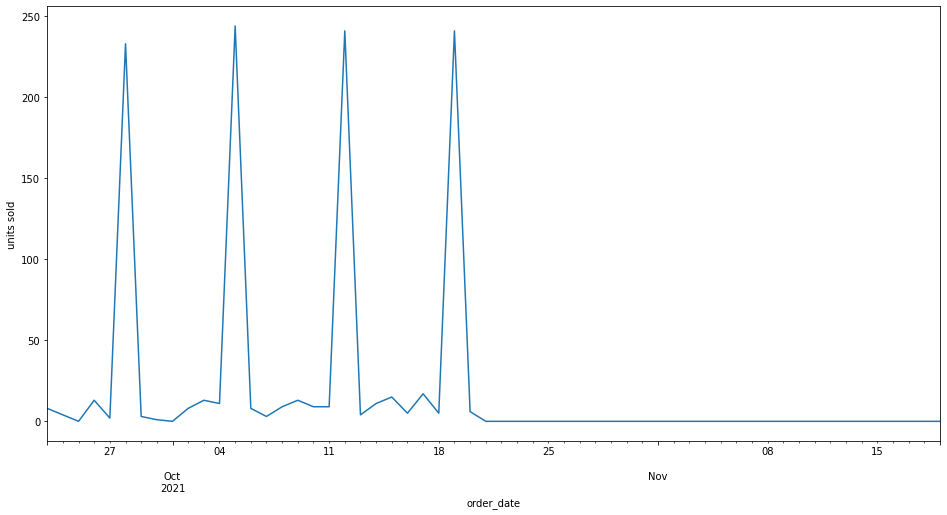

In [ ]:
ax = forecast[forecast.sku == 'L7CJE9'][['order_date', 'units_sold']].groupby(by='order_date').sum()['units_sold'].astype(int).plot(figsize=(16,8))
ax.set_ylabel("units sold")

In [ ]:
# TODO calcualte safety stock column
products['safety_stock'] = products.apply(lambda r: simple_safety_stock(z_score,r["rmse"],r["days_until_next_delivery"] ), axis=1)
products.head()

,country_code,sku,product_name,barcode,store,warehouse_id,is_active,supplier_id,min_qty,preference,trade_cost_lp,latest_delivery_date,last_po_order_qty,last_po_delivered_qty,last_po_fill_rate,days_to_expiration,expiration_date,sales_buffer,stock_on_hand,on_hand_stock_date,stock_in_transit,in_transit_stock_date,on_hand_minus_transfer_req,transfer_stock,availability,units_sold,units_sold_7d,avg_units_sold,wh_sku,global_entity_id,supplier_name,lead_time,max_stock_days,delivery_mon,delivery_tue,delivery_wed,delivery_thu,delivery_fri,delivery_sat,next_delivery_date,subsequent_delivery_date,days_until_next_delivery,forecast_aggregated_days_until_next_delivery,delivery_day_plus_stock_days,forecast_aggregated_delivery_day_plus_stock_days,cycle_sales,sell_out_day,rmse,safety_stock
0,se,8930FB,Findus nFine fillets of cod MSC 375g,7310500184302,foodora market Östermalm,87d47f17-25cc-4e89-9bbc-3df289eba49d,True,7,11.0,1.0,4818.0,2021-10-06,11.0,11.0,1.0,452.0,2021-10-21,0,3,2021-10-20 09:19:39.465032,0,NaT,3,0,1.00,15,3,0.3261,87d47f17-25cc-4e89-9bbc-3df289eba49d_8930FB,OP_SE,Bergendahl,2,9,True,None,True,None,True,None,2021-10-25 12:30:24.336803,2021-10-27 12:30:24.336803,4,1.924690,13,5.659314,3.734624,2021-10-28 12:30:24.336803,0.915889,2.347517
1,se,YJJI4O,Greendeli Yoghurt Granola honung 210g,7350035639656,foodora market Östermalm,87d47f17-25cc-4e89-9bbc-3df289eba49d,True,34,1.0,1.0,1912.0,2021-10-20,2.0,2.0,1.0,6.0,2021-10-21,0,2,2021-10-20 07:32:19.354187,4,2021-10-20 10:18:02.271336,2,0,0.17,4,4,0.1081,87d47f17-25cc-4e89-9bbc-3df289eba49d_YJJI4O,OP_SE,Picadeli AB,7,9,None,None,None,True,None,None,2021-10-28 12:30:24.336803,2021-11-04 12:30:24.336803,7,3.036745,16,6.064600,3.027855,2021-11-06 12:30:24.336803,0.615320,2.086346
2,se,L7CJE9,Ramlösa Citrus 330ml,"7310070004765,7310070766083",foodora market Östermalm,87d47f17-25cc-4e89-9bbc-3df289eba49d,True,7,20.0,1.0,344.0,2021-10-20,400.0,400.0,1.0,272.0,2021-10-21,1,556,2021-10-20 10:44:32.101852,0,NaT,556,0,1.00,1028,252,5.064,87d47f17-25cc-4e89-9bbc-3df289eba49d_L7CJE9,OP_SE,Bergendahl,2,9,True,None,True,None,True,None,2021-10-25 12:30:24.336803,2021-10-27 12:30:24.336803,4,16.217210,13,38.721631,22.504421,NaT,87.197387,223.495896
3,se,802VFE,Remi Mint Cookie 100g,7310525701416,foodora market Östermalm,87d47f17-25cc-4e89-9bbc-3df289eba49d,True,7,22.0,1.0,1633.0,2021-07-12,22.0,22.0,1.0,297.0,2021-10-21,0,17,2021-10-18 17:22:11.355841,0,NaT,17,0,1.00,7,1,0.0833,87d47f17-25cc-4e89-9bbc-3df289eba49d_802VFE,OP_SE,Bergendahl,2,9,True,None,True,None,True,None,2021-10-25 12:30:24.336803,2021-10-27 12:30:24.336803,4,1.034318,13,3.192781,2.158463,NaT,0.596728,1.529476
4,se,B12YH6,Toms Salta Hallon Stång 29 g,5774540465401,foodora market Östermalm,87d47f17-25cc-4e89-9bbc-3df289eba49d,True,7,55.0,1.0,212.0,2021-10-08,55.0,55.0,1.0,524.0,2021-10-21,1,37,2021-10-20 20:15:13.289378,0,NaT,37,0,1.00,67,16,0.3941,87d47f17-25cc-4e89-9bbc-3df289eba49d_B12YH6,OP_SE,Bergendahl,2,9,True,None,True,None,True,None,2021-10-25 12:30:24.336803,2021-10-27 12:30:24.336803,4,10.000000,13,28.000000,18.000000,2021-11-08 12:30:24.336803,2.515539,6.447587


In [ ]:
products.sku.unique().shape

(2215,)

In [ ]:
products[products.safety_stock < 0].head()

,country_code,sku,product_name,barcode,store,warehouse_id,is_active,supplier_id,min_qty,preference,trade_cost_lp,latest_delivery_date,last_po_order_qty,last_po_delivered_qty,last_po_fill_rate,days_to_expiration,expiration_date,sales_buffer,stock_on_hand,on_hand_stock_date,stock_in_transit,in_transit_stock_date,on_hand_minus_transfer_req,transfer_stock,availability,units_sold,units_sold_7d,avg_units_sold,wh_sku,global_entity_id,supplier_name,lead_time,max_stock_days,delivery_mon,delivery_tue,delivery_wed,delivery_thu,delivery_fri,delivery_sat,next_delivery_date,subsequent_delivery_date,days_until_next_delivery,forecast_aggregated_days_until_next_delivery,delivery_day_plus_stock_days,forecast_aggregated_delivery_day_plus_stock_days,cycle_sales,sell_out_day,rmse,safety_stock


In [ ]:
products[products['sku'] == '2F544M']

,country_code,sku,product_name,barcode,store,warehouse_id,is_active,supplier_id,min_qty,preference,trade_cost_lp,latest_delivery_date,last_po_order_qty,last_po_delivered_qty,last_po_fill_rate,days_to_expiration,expiration_date,sales_buffer,stock_on_hand,on_hand_stock_date,stock_in_transit,in_transit_stock_date,on_hand_minus_transfer_req,transfer_stock,availability,units_sold,units_sold_7d,avg_units_sold,wh_sku,global_entity_id,supplier_name,lead_time,max_stock_days,delivery_mon,delivery_tue,delivery_wed,delivery_thu,delivery_fri,delivery_sat,next_delivery_date,subsequent_delivery_date,days_until_next_delivery,forecast_aggregated_days_until_next_delivery,delivery_day_plus_stock_days,forecast_aggregated_delivery_day_plus_stock_days,cycle_sales,sell_out_day,rmse,safety_stock
44,se,2F544M,Ramlösa Original 330ml,"7310070766144,7310070004758",foodora market Östermalm,87d47f17-25cc-4e89-9bbc-3df289eba49d,True,7,20.0,1.0,317.0,2021-10-20,400.0,400.0,1.0,345.0,2021-10-21,1,391,2021-10-20 22:01:35.923997,100,2021-10-20 16:12:14.632979,391,0,0.91,842,276,6.3788,87d47f17-25cc-4e89-9bbc-3df289eba49d_2F544M,OP_SE,Bergendahl,2,9,True,None,True,None,True,None,2021-10-25 12:30:24.336803,2021-10-27 12:30:24.336803,4,29.921932,13,44.784931,14.863,NaT,75.974807,194.731267


In [ ]:
rmses[f'{warehouse_id}_L7CJE9']

87.19738695749264

In [ ]:
products.sku.unique().shape

(2215,)

In [ ]:
#TODO calculate final units needed per product
# consider sotck on-hand, in-transit, in-transfer
# (cycle_sales + safety_stock) - (stock_on_hand + stock_in_transit - sales_to_delivery)
products["final_need"]  = products["cycle_sales"] + products["safety_stock"] - products["stock_in_transit"] - products["stock_on_hand"] + products["forecast_aggregated_days_until_next_delivery"]
products['final_need'] = products['final_need'].apply(lambda x: 0 if x < 0 else x)
products[products['final_need'] == 0].head()

,country_code,sku,product_name,barcode,store,warehouse_id,is_active,supplier_id,min_qty,preference,trade_cost_lp,latest_delivery_date,last_po_order_qty,last_po_delivered_qty,last_po_fill_rate,days_to_expiration,expiration_date,sales_buffer,stock_on_hand,on_hand_stock_date,stock_in_transit,in_transit_stock_date,on_hand_minus_transfer_req,transfer_stock,availability,units_sold,units_sold_7d,avg_units_sold,wh_sku,global_entity_id,supplier_name,lead_time,max_stock_days,delivery_mon,delivery_tue,delivery_wed,delivery_thu,delivery_fri,delivery_sat,next_delivery_date,subsequent_delivery_date,days_until_next_delivery,forecast_aggregated_days_until_next_delivery,delivery_day_plus_stock_days,forecast_aggregated_delivery_day_plus_stock_days,cycle_sales,sell_out_day,rmse,safety_stock,final_need
2,se,L7CJE9,Ramlösa Citrus 330ml,"7310070004765,7310070766083",foodora market Östermalm,87d47f17-25cc-4e89-9bbc-3df289eba49d,True,7,20.0,1.0,344.0,2021-10-20,400.0,400.0,1.0,272.0,2021-10-21,1,556,2021-10-20 10:44:32.101852,0,NaT,556,0,1.00,1028,252,5.064,87d47f17-25cc-4e89-9bbc-3df289eba49d_L7CJE9,OP_SE,Bergendahl,2,9,True,None,True,None,True,None,2021-10-25 12:30:24.336803,2021-10-27 12:30:24.336803,4,16.217210,13,38.721631,22.504421,NaT,87.197387,223.495896,0.0
3,se,802VFE,Remi Mint Cookie 100g,7310525701416,foodora market Östermalm,87d47f17-25cc-4e89-9bbc-3df289eba49d,True,7,22.0,1.0,1633.0,2021-07-12,22.0,22.0,1.0,297.0,2021-10-21,0,17,2021-10-18 17:22:11.355841,0,NaT,17,0,1.00,7,1,0.0833,87d47f17-25cc-4e89-9bbc-3df289eba49d_802VFE,OP_SE,Bergendahl,2,9,True,None,True,None,True,None,2021-10-25 12:30:24.336803,2021-10-27 12:30:24.336803,4,1.034318,13,3.192781,2.158463,NaT,0.596728,1.529476,0.0
4,se,B12YH6,Toms Salta Hallon Stång 29 g,5774540465401,foodora market Östermalm,87d47f17-25cc-4e89-9bbc-3df289eba49d,True,7,55.0,1.0,212.0,2021-10-08,55.0,55.0,1.0,524.0,2021-10-21,1,37,2021-10-20 20:15:13.289378,0,NaT,37,0,1.00,67,16,0.3941,87d47f17-25cc-4e89-9bbc-3df289eba49d_B12YH6,OP_SE,Bergendahl,2,9,True,None,True,None,True,None,2021-10-25 12:30:24.336803,2021-10-27 12:30:24.336803,4,10.000000,13,28.000000,18.000000,2021-11-08 12:30:24.336803,2.515539,6.447587,0.0
6,se,A7162G,El Taco Truck Sweet Potato Burrito 170g,7350115908030,foodora market Östermalm,87d47f17-25cc-4e89-9bbc-3df289eba49d,True,13,13.0,1.0,2352.0,2021-10-13,26.0,26.0,1.0,337.0,2021-10-21,0,43,2021-10-20 21:04:21.363162,0,NaT,43,0,0.99,46,7,0.7419,87d47f17-25cc-4e89-9bbc-3df289eba49d_A7162G,OP_SE,Out of Home,7,9,None,None,True,None,None,None,2021-11-03 12:30:24.336803,2021-11-10 12:30:24.336803,13,10.000000,22,16.428571,6.428571,NaT,1.944515,8.985022,0.0
7,se,W9W9Q3,Marabou Drömkrisp 100g,7622210059956,foodora market Östermalm,87d47f17-25cc-4e89-9bbc-3df289eba49d,True,7,22.0,1.0,947.0,2021-09-03,66.0,66.0,1.0,NaN,2021-10-21,1,49,2021-10-16 22:03:25.152773,0,NaT,49,0,1.00,35,4,0.1122,87d47f17-25cc-4e89-9bbc-3df289eba49d_W9W9Q3,OP_SE,Bergendahl,2,9,True,None,True,None,True,None,2021-10-25 12:30:24.336803,2021-10-27 12:30:24.336803,4,2.857143,13,8.000000,5.142857,NaT,1.644436,4.214858,0.0


In [ ]:
#TODO calculate final packs needed per product
# total units/pack size, rounded to next pack (always round up!)
products["final_packs"] = (products["final_need"] / products["min_qty"]).apply(np.ceil)
products.head()

,country_code,sku,product_name,barcode,store,warehouse_id,is_active,supplier_id,min_qty,preference,trade_cost_lp,latest_delivery_date,last_po_order_qty,last_po_delivered_qty,last_po_fill_rate,days_to_expiration,expiration_date,sales_buffer,stock_on_hand,on_hand_stock_date,stock_in_transit,in_transit_stock_date,on_hand_minus_transfer_req,transfer_stock,availability,units_sold,units_sold_7d,avg_units_sold,wh_sku,global_entity_id,supplier_name,lead_time,max_stock_days,delivery_mon,delivery_tue,delivery_wed,delivery_thu,delivery_fri,delivery_sat,next_delivery_date,subsequent_delivery_date,days_until_next_delivery,forecast_aggregated_days_until_next_delivery,delivery_day_plus_stock_days,forecast_aggregated_delivery_day_plus_stock_days,cycle_sales,sell_out_day,rmse,safety_stock,final_need,final_packs
0,se,8930FB,Findus nFine fillets of cod MSC 375g,7310500184302,foodora market Östermalm,87d47f17-25cc-4e89-9bbc-3df289eba49d,True,7,11.0,1.0,4818.0,2021-10-06,11.0,11.0,1.0,452.0,2021-10-21,0,3,2021-10-20 09:19:39.465032,0,NaT,3,0,1.00,15,3,0.3261,87d47f17-25cc-4e89-9bbc-3df289eba49d_8930FB,OP_SE,Bergendahl,2,9,True,None,True,None,True,None,2021-10-25 12:30:24.336803,2021-10-27 12:30:24.336803,4,1.924690,13,5.659314,3.734624,2021-10-28 12:30:24.336803,0.915889,2.347517,5.006831,1.0
1,se,YJJI4O,Greendeli Yoghurt Granola honung 210g,7350035639656,foodora market Östermalm,87d47f17-25cc-4e89-9bbc-3df289eba49d,True,34,1.0,1.0,1912.0,2021-10-20,2.0,2.0,1.0,6.0,2021-10-21,0,2,2021-10-20 07:32:19.354187,4,2021-10-20 10:18:02.271336,2,0,0.17,4,4,0.1081,87d47f17-25cc-4e89-9bbc-3df289eba49d_YJJI4O,OP_SE,Picadeli AB,7,9,None,None,None,True,None,None,2021-10-28 12:30:24.336803,2021-11-04 12:30:24.336803,7,3.036745,16,6.064600,3.027855,2021-11-06 12:30:24.336803,0.615320,2.086346,2.150946,3.0
2,se,L7CJE9,Ramlösa Citrus 330ml,"7310070004765,7310070766083",foodora market Östermalm,87d47f17-25cc-4e89-9bbc-3df289eba49d,True,7,20.0,1.0,344.0,2021-10-20,400.0,400.0,1.0,272.0,2021-10-21,1,556,2021-10-20 10:44:32.101852,0,NaT,556,0,1.00,1028,252,5.064,87d47f17-25cc-4e89-9bbc-3df289eba49d_L7CJE9,OP_SE,Bergendahl,2,9,True,None,True,None,True,None,2021-10-25 12:30:24.336803,2021-10-27 12:30:24.336803,4,16.217210,13,38.721631,22.504421,NaT,87.197387,223.495896,0.000000,0.0
3,se,802VFE,Remi Mint Cookie 100g,7310525701416,foodora market Östermalm,87d47f17-25cc-4e89-9bbc-3df289eba49d,True,7,22.0,1.0,1633.0,2021-07-12,22.0,22.0,1.0,297.0,2021-10-21,0,17,2021-10-18 17:22:11.355841,0,NaT,17,0,1.00,7,1,0.0833,87d47f17-25cc-4e89-9bbc-3df289eba49d_802VFE,OP_SE,Bergendahl,2,9,True,None,True,None,True,None,2021-10-25 12:30:24.336803,2021-10-27 12:30:24.336803,4,1.034318,13,3.192781,2.158463,NaT,0.596728,1.529476,0.000000,0.0
4,se,B12YH6,Toms Salta Hallon Stång 29 g,5774540465401,foodora market Östermalm,87d47f17-25cc-4e89-9bbc-3df289eba49d,True,7,55.0,1.0,212.0,2021-10-08,55.0,55.0,1.0,524.0,2021-10-21,1,37,2021-10-20 20:15:13.289378,0,NaT,37,0,1.00,67,16,0.3941,87d47f17-25cc-4e89-9bbc-3df289eba49d_B12YH6,OP_SE,Bergendahl,2,9,True,None,True,None,True,None,2021-10-25 12:30:24.336803,2021-10-27 12:30:24.336803,4,10.000000,13,28.000000,18.000000,2021-11-08 12:30:24.336803,2.515539,6.447587,0.000000,0.0


In [ ]:
products[products['sku'] == 'L7CJE9'].shape

(1, 51)

In [ ]:
#TODO calculate total $$ amount needed (unit price * quantity needed)
products["total_amount_needed"] = products["trade_cost_lp"] * products["min_qty"] * products["final_packs"]. apply(np.ceil)
products.head()


,country_code,sku,product_name,barcode,store,warehouse_id,is_active,supplier_id,min_qty,preference,trade_cost_lp,latest_delivery_date,last_po_order_qty,last_po_delivered_qty,last_po_fill_rate,days_to_expiration,expiration_date,sales_buffer,stock_on_hand,on_hand_stock_date,stock_in_transit,in_transit_stock_date,on_hand_minus_transfer_req,transfer_stock,availability,units_sold,units_sold_7d,avg_units_sold,wh_sku,global_entity_id,supplier_name,lead_time,max_stock_days,delivery_mon,delivery_tue,delivery_wed,delivery_thu,delivery_fri,delivery_sat,next_delivery_date,subsequent_delivery_date,days_until_next_delivery,forecast_aggregated_days_until_next_delivery,delivery_day_plus_stock_days,forecast_aggregated_delivery_day_plus_stock_days,cycle_sales,sell_out_day,rmse,safety_stock,final_need,final_packs,total_amount_needed
0,se,8930FB,Findus nFine fillets of cod MSC 375g,7310500184302,foodora market Östermalm,87d47f17-25cc-4e89-9bbc-3df289eba49d,True,7,11.0,1.0,4818.0,2021-10-06,11.0,11.0,1.0,452.0,2021-10-21,0,3,2021-10-20 09:19:39.465032,0,NaT,3,0,1.00,15,3,0.3261,87d47f17-25cc-4e89-9bbc-3df289eba49d_8930FB,OP_SE,Bergendahl,2,9,True,None,True,None,True,None,2021-10-25 12:30:24.336803,2021-10-27 12:30:24.336803,4,1.924690,13,5.659314,3.734624,2021-10-28 12:30:24.336803,0.915889,2.347517,5.006831,1.0,52998.0
1,se,YJJI4O,Greendeli Yoghurt Granola honung 210g,7350035639656,foodora market Östermalm,87d47f17-25cc-4e89-9bbc-3df289eba49d,True,34,1.0,1.0,1912.0,2021-10-20,2.0,2.0,1.0,6.0,2021-10-21,0,2,2021-10-20 07:32:19.354187,4,2021-10-20 10:18:02.271336,2,0,0.17,4,4,0.1081,87d47f17-25cc-4e89-9bbc-3df289eba49d_YJJI4O,OP_SE,Picadeli AB,7,9,None,None,None,True,None,None,2021-10-28 12:30:24.336803,2021-11-04 12:30:24.336803,7,3.036745,16,6.064600,3.027855,2021-11-06 12:30:24.336803,0.615320,2.086346,2.150946,3.0,5736.0
2,se,L7CJE9,Ramlösa Citrus 330ml,"7310070004765,7310070766083",foodora market Östermalm,87d47f17-25cc-4e89-9bbc-3df289eba49d,True,7,20.0,1.0,344.0,2021-10-20,400.0,400.0,1.0,272.0,2021-10-21,1,556,2021-10-20 10:44:32.101852,0,NaT,556,0,1.00,1028,252,5.064,87d47f17-25cc-4e89-9bbc-3df289eba49d_L7CJE9,OP_SE,Bergendahl,2,9,True,None,True,None,True,None,2021-10-25 12:30:24.336803,2021-10-27 12:30:24.336803,4,16.217210,13,38.721631,22.504421,NaT,87.197387,223.495896,0.000000,0.0,0.0
3,se,802VFE,Remi Mint Cookie 100g,7310525701416,foodora market Östermalm,87d47f17-25cc-4e89-9bbc-3df289eba49d,True,7,22.0,1.0,1633.0,2021-07-12,22.0,22.0,1.0,297.0,2021-10-21,0,17,2021-10-18 17:22:11.355841,0,NaT,17,0,1.00,7,1,0.0833,87d47f17-25cc-4e89-9bbc-3df289eba49d_802VFE,OP_SE,Bergendahl,2,9,True,None,True,None,True,None,2021-10-25 12:30:24.336803,2021-10-27 12:30:24.336803,4,1.034318,13,3.192781,2.158463,NaT,0.596728,1.529476,0.000000,0.0,0.0
4,se,B12YH6,Toms Salta Hallon Stång 29 g,5774540465401,foodora market Östermalm,87d47f17-25cc-4e89-9bbc-3df289eba49d,True,7,55.0,1.0,212.0,2021-10-08,55.0,55.0,1.0,524.0,2021-10-21,1,37,2021-10-20 20:15:13.289378,0,NaT,37,0,1.00,67,16,0.3941,87d47f17-25cc-4e89-9bbc-3df289eba49d_B12YH6,OP_SE,Bergendahl,2,9,True,None,True,None,True,None,2021-10-25 12:30:24.336803,2021-10-27 12:30:24.336803,4,10.000000,13,28.000000,18.000000,2021-11-08 12:30:24.336803,2.515539,6.447587,0.000000,0.0,0.0


# Filter products to order

In [ ]:
#Calculate flag to order or not (if there are packs needed and MOQ is reached)
products_to_order = products[ products["final_packs"] > 0 ]
print(len(products))
print(len(products_to_order))
print("Total Cost :", products["total_amount_needed"].sum()  )

2215
755
Total Cost : 31745436.0


In [ ]:
products[products['sku'] == 'L7CJE9'].shape

(1, 52)

In [ ]:
products_to_order[products_to_order['sku'] == 'L7CJE9'].shape

(0, 52)

# Calculate all other columns

In [ ]:
test = products_to_order.copy()

In [ ]:
products.shape

(2215, 52)

In [ ]:
products.sku.unique().shape

(2215,)

In [ ]:
products_to_order.shape

(755, 52)

In [ ]:
products_to_order.sku.unique().shape

(755,)

In [ ]:
test.columns

Index(['country_code', 'sku', 'product_name', 'barcode', 'store',
       'warehouse_id', 'is_active', 'supplier_id', 'min_qty', 'preference',
       'trade_cost_lp', 'latest_delivery_date', 'last_po_order_qty',
       'last_po_delivered_qty', 'last_po_fill_rate', 'days_to_expiration',
       'expiration_date', 'sales_buffer', 'stock_on_hand',
       'on_hand_stock_date', 'stock_in_transit', 'in_transit_stock_date',
       'on_hand_minus_transfer_req', 'transfer_stock', 'availability',
       'units_sold', 'units_sold_7d', 'avg_units_sold', 'wh_sku',
       'global_entity_id', 'supplier_name', 'lead_time', 'max_stock_days',
       'delivery_mon', 'delivery_tue', 'delivery_wed', 'delivery_thu',
       'delivery_fri', 'delivery_sat', 'next_delivery_date',
       'subsequent_delivery_date', 'days_until_next_delivery',
       'forecast_aggregated_days_until_next_delivery',
       'delivery_day_plus_stock_days',
       'forecast_aggregated_delivery_day_plus_stock_days', 'cycle_sales',
      

In [ ]:
# Order deadline date
test['Order deadline date'] = test.apply(lambda row: pd.to_datetime(row['next_delivery_date']) - pd.Timedelta(days=row['lead_time']), axis=1).dt.date

In [ ]:
products_to_order.is_active.unique()

array([ True])

In [ ]:
test[['Order deadline date', 'next_delivery_date', 'lead_time']].head()

,Order deadline date,next_delivery_date,lead_time
0,2021-10-23,2021-10-25 12:30:24.336803,2
1,2021-10-21,2021-10-28 12:30:24.336803,7
5,2021-10-23,2021-10-25 12:30:24.336803,2
11,2021-10-21,2021-10-23 12:30:24.336803,2
19,2021-10-23,2021-10-25 12:30:24.336803,2


In [ ]:
test['Next possible delivery date'] = test['next_delivery_date']
# test.drop(columns=('next_delivery_date'))

In [ ]:
# Stock Final (SiT+SoH+TS-Buffer)
test['Stock Final'] = test['stock_in_transit'] + test['stock_on_hand'] + test['transfer_stock'] - test['sales_buffer']

In [ ]:
# Days to subsequent delivery
test['Days to subsequent delivery'] = (test['subsequent_delivery_date']  - test['next_delivery_date']).dt.days
# test.drop(columns=['subsequent_delivery_date'])

In [ ]:
# Stock days to be covered
# Minimun of 
# - days to expiration
# - max stock days
# - days to subsequent delivery
test['Stock days to be covered'] = test.apply(lambda row: min([row['max_stock_days'],  row['Days to subsequent delivery'], row['days_to_expiration']]), axis=1)    # TODO: add days to expiration

In [ ]:
#BUCKET

#NOTE: Coppied from APAC

from collections import defaultdict

min_threshold_percentage = 0.25 # For availability
APAC_SABCD_BUCKET_CUTOFFS = {0.24: 'D', 0.49: 'C', 0.74: 'B', 0.94: 'A', 1.00: 'S'}  # e.g. 0->0.24 == D


def calculate_potential_sales(products: pd.DataFrame, min_avail: float=min_threshold_percentage) -> pd.DataFrame:
    """
    Calculates potential sales from actual sales and availability
    """

    products['availability'] = products['availability'].apply(lambda x: min_avail if x <= min_avail else x)
    products['potential_sales'] = products['units_sold'].astype(float) / products['availability'].astype(float)
    # products['potential_sales'].fillna(0, inplace=True)  # Explicitly leave nulls to distinguish from calc'd 0
    return products


def calculate_penetration(products: pd.DataFrame, group_by_columns: list) -> pd.DataFrame:
    """
    Calculates unit penetration
    """

    grouped = products.groupby(by=group_by_columns)['potential_sales'].sum().rename('grouped_units').reset_index()
    products = products.merge(grouped, on=group_by_columns)
    products['unit_penetration'] = (
            products['potential_sales'].astype(float) / products['grouped_units'].astype(float)
    ).to_numpy().astype(float).round(4)

    # Remove columns intended only for unit-penetration calc
    products.drop(columns=['potential_sales', 'grouped_units'], inplace=True)

    return products


def calculate_the_abc_buckets(products: pd.DataFrame, bucket_cutoffs: dict=APAC_SABCD_BUCKET_CUTOFFS): 

    quantiles = bucket_cutoffs.keys()
    warehouse_id_to_quantile_list_map = defaultdict(list)
    warehouse_ids = products['warehouse_id'].unique()

    for quant in quantiles:
        for _id in warehouse_ids:
            warehouse_id_to_quantile_list_map[_id].append(
                products[products['warehouse_id'] == _id]['unit_penetration'].sort_values().quantile(quant))

    def get_percentile(warehouse_id_unit_pen_obj):
        warehouse_percentile_list = warehouse_id_to_quantile_list_map[warehouse_id_unit_pen_obj['warehouse_id']]
        for warehouse_value, perc in zip(sorted(warehouse_percentile_list), sorted(quantiles)):
            if warehouse_id_unit_pen_obj['unit_penetration'] > warehouse_value:
                continue
            return perc

    products['quantile'] = products[['warehouse_id', 'unit_penetration']].apply(get_percentile, axis=1)
    products['bucket'] = products['quantile'].apply(lambda x: bucket_cutoffs.get(x))

    products.drop(columns=['quantile'], inplace=True)

    return products



In [ ]:
test = test.pipe(calculate_potential_sales).pipe(calculate_penetration, ['warehouse_id']).pipe(calculate_the_abc_buckets)

In [ ]:
test[['unit_penetration', 'bucket']].head()

,unit_penetration,bucket
0,0.0003,D
1,0.0003,D
2,0.0005,C
3,0.0116,S
4,0.0003,D


In [ ]:
# Days to Expiration

test['Days to Expiration'] = test['days_to_expiration']
#test.drop(columns=['days_to_expiration'])

test['Batch experiation date'] = test['expiration_date']
#test.drop(columns=['expiration_date'])

In [ ]:
# Place order
# place order for active SKUs if the Final need packs is > 0, or if Final need pack = 0 and stock on hand is 0 (for new active skus order 1 MOQ)

test['Place Order'] = test.apply(lambda row: (( (row['is_active'] == True) and (row['final_packs'] > 0) ) or ( (row['final_packs'] == 0)  and (row['stock_on_hand'] == 0) )), axis=1)

# Rename Columns

In [ ]:
test.rename(columns={
    'warehouse_id': 'Warehouse ID',
    'sku' : 'SKU',
    'product_name': 'Product name',
    'latest_delivery_date': 'Last delivery date',
    'last_po_order_qty': 'Ordered Qty',
    'last_po_delivered_qty': 'Received Qty',
    'last_po_fill_rate': 'Supplier fill rate',
    'supplier_id': 'Supplier ID',
    'supplier_name': 'Supplier Name',
    'is_active': 'SKU status supllier portal',
    'min_qty': 'Units in Case',
    'max_stock_days': 'Maximum stock days',
    'stock_on_hand': 'Stock on hand',
    'stock_in_transit': 'Stock in transit (PO)',
    'transfer_stock':  'Transfer Stock (ST)',
    'sales_buffer': 'Sales Buffer (Catalog)',
    'availability': 'Availability (28d)',
    'units_sold': 'Units Sold (28d)',
    'units_sold_7d': 'Units sold (7d)',
    'avg_units_sold': 'Avg daily Sales',
    'forecast_aggregated_days_until_next_delivery': 'Sales to next delivery',
    'cycle_sales': 'Cycle Sales (to subsequent delivery)',
    'sell_out_day': 'Sell-out date',
    'rmse': 'RMSE FC',
    'avg_lead_time': 'Avg Lead days',
    'std_lead_time': 'St dev lead time',
    'safety_stock': 'Safety Stock',
    'final_need': 'Final Need Units',
    'final_packs': 'Final Need Packs',
    'total_amount_needed': 'Final Need Value',
    'days_until_next_delivery': 'Days to next delivery',
    'bucket': 'Bucket',
    'barcode': 'Barcode',
    'store': 'Warehouse name'

},
inplace=True
)

In [ ]:
test['MOQ'] = 1

In [ ]:
test['Target Service Level'] = target_service_level

In [ ]:
test['Forecast Uplift %'] = np.nan  # TODO: Get from manual sheet

In [ ]:
test.columns

Index(['country_code', 'SKU', 'Product name', 'Barcode', 'Warehouse name',
       'Warehouse ID', 'SKU status supllier portal', 'Supplier ID',
       'Units in Case', 'preference', 'trade_cost_lp', 'Last delivery date',
       'Ordered Qty', 'Received Qty', 'Supplier fill rate',
       'days_to_expiration', 'expiration_date', 'Sales Buffer (Catalog)',
       'Stock on hand', 'on_hand_stock_date', 'Stock in transit (PO)',
       'in_transit_stock_date', 'on_hand_minus_transfer_req',
       'Transfer Stock (ST)', 'Availability (28d)', 'Units Sold (28d)',
       'Units sold (7d)', 'Avg daily Sales', 'wh_sku', 'global_entity_id',
       'Supplier Name', 'lead_time', 'Maximum stock days', 'delivery_mon',
       'delivery_tue', 'delivery_wed', 'delivery_thu', 'delivery_fri',
       'delivery_sat', 'next_delivery_date', 'subsequent_delivery_date',
       'Days to next delivery', 'Sales to next delivery',
       'delivery_day_plus_stock_days',
       'forecast_aggregated_delivery_day_plus_stoc

# Re-org Columns

In [ ]:
result = test[[
      'Warehouse ID', 'Warehouse name', 'SKU', 'Barcode', 'Product name', 'Last delivery date', 'Batch experiation date', 'Ordered Qty', 'Received Qty', 'Supplier fill rate', 'Days to Expiration',
      'Supplier ID', 'Supplier Name', 'SKU status supllier portal', 'Units in Case', 'MOQ', 'Next possible delivery date', 'Order deadline date', 'Days to next delivery',
      'Days to subsequent delivery', 'Maximum stock days', 'Stock days to be covered', 'Stock on hand', 'Stock in transit (PO)',
      'Transfer Stock (ST)', 'Sales Buffer (Catalog)', 'Stock Final', 'Availability (28d)', 'Units Sold (28d)',  'Units sold (7d)', 'Avg daily Sales', 'Bucket',
      'Target Service Level', 'Sales to next delivery',  'Cycle Sales (to subsequent delivery)', 'Sell-out date', 'RMSE FC', 'Safety Stock',
      'Final Need Units', 'Final Need Packs', 'Final Need Value', 'Place Order'

]].copy()

In [ ]:
result.columns

Index(['Warehouse ID', 'Warehouse name', 'SKU', 'Barcode', 'Product name',
       'Last delivery date', 'Batch experiation date', 'Ordered Qty',
       'Received Qty', 'Supplier fill rate', 'Days to Expiration',
       'Supplier ID', 'Supplier Name', 'SKU status supllier portal',
       'Units in Case', 'MOQ', 'Next possible delivery date',
       'Order deadline date', 'Days to next delivery',
       'Days to subsequent delivery', 'Maximum stock days',
       'Stock days to be covered', 'Stock on hand', 'Stock in transit (PO)',
       'Transfer Stock (ST)', 'Sales Buffer (Catalog)', 'Stock Final',
       'Availability (28d)', 'Units Sold (28d)', 'Units sold (7d)',
       'Avg daily Sales', 'Bucket', 'Target Service Level',
       'Sales to next delivery', 'Cycle Sales (to subsequent delivery)',
       'Sell-out date', 'RMSE FC', 'Safety Stock', 'Final Need Units',
       'Final Need Packs', 'Final Need Value', 'Place Order'],
      dtype='object')

In [ ]:
# Convert all date columns to date, not datetime

date_columns = ['Last delivery date', 'Batch experiation date', 'Next possible delivery date', 'Sell-out date']
result['Last delivery date'] = pd.to_datetime(result['Last delivery date']).dt.date
result['Batch experiation date'] = pd.to_datetime(result['Batch experiation date']).dt.date
result['Next possible delivery date'] = pd.to_datetime(result['Next possible delivery date']).dt.date
result['Sell-out date'] = pd.to_datetime(result['Sell-out date']).dt.date



In [ ]:
# adjust precision on float dtype column
result['RMSE FC'] = result['RMSE FC'].round(2)
result['Supplier fill rate'] = result['Supplier fill rate'].round(2)
result['Avg daily Sales'] = test['Avg daily Sales'].astype(np.float64).round(2)


# convert int column types
result['Cycle Sales (to subsequent delivery)'] = result['Cycle Sales (to subsequent delivery)'].apply(np.ceil).astype(int)
result['Safety Stock'] = result['Safety Stock'].apply(np.ceil).astype(int)
result['Final Need Units'] = result['Final Need Units'].apply(np.ceil).astype(int)
result['Sales to next delivery'] = result['Sales to next delivery'].apply(np.ceil).astype(int)

In [ ]:
result['Cycle Sales (to subsequent delivery)'].head()

0      4
1      4
2      8
3    112
4      4
Name: Cycle Sales (to subsequent delivery), dtype: int64

In [ ]:
#Update Boolean columns to Yes, NO

result['Place Order'] = result.apply(lambda row: 'YES' if row['Place Order'] else '', axis=1)
# result['SKU status supllier portal'] = result.apply(lambda row: 'Yes' if row['SKU status supllier portal'] else 'No', axis=1)



In [ ]:
test['Avg daily Sales'].astype(np.float64).round(2)

0      0.33
1      0.11
2      0.08
3      0.14
4      0.31
       ... 
750    0.16
751    0.13
752    0.24
753    0.29
754    0.13
Name: Avg daily Sales, Length: 755, dtype: float64

In [ ]:
test.shape

(755, 65)

In [ ]:
test.SKU.unique().shape

(755,)

In [ ]:
test.columns

Index(['country_code', 'SKU', 'Product name', 'Barcode', 'Warehouse name',
       'Warehouse ID', 'SKU status supllier portal', 'Supplier ID',
       'Units in Case', 'preference', 'trade_cost_lp', 'Last delivery date',
       'Ordered Qty', 'Received Qty', 'Supplier fill rate',
       'days_to_expiration', 'expiration_date', 'Sales Buffer (Catalog)',
       'Stock on hand', 'on_hand_stock_date', 'Stock in transit (PO)',
       'in_transit_stock_date', 'on_hand_minus_transfer_req',
       'Transfer Stock (ST)', 'Availability (28d)', 'Units Sold (28d)',
       'Units sold (7d)', 'Avg daily Sales', 'wh_sku', 'global_entity_id',
       'Supplier Name', 'lead_time', 'Maximum stock days', 'delivery_mon',
       'delivery_tue', 'delivery_wed', 'delivery_thu', 'delivery_fri',
       'delivery_sat', 'next_delivery_date', 'subsequent_delivery_date',
       'Days to next delivery', 'Sales to next delivery',
       'delivery_day_plus_stock_days',
       'forecast_aggregated_delivery_day_plus_stoc

In [ ]:
test.drop_duplicates().shape

(755, 65)

In [ ]:
result.columns

Index(['Warehouse ID', 'Warehouse name', 'SKU', 'Barcode', 'Product name',
       'Last delivery date', 'Batch experiation date', 'Ordered Qty',
       'Received Qty', 'Supplier fill rate', 'Days to Expiration',
       'Supplier ID', 'Supplier Name', 'SKU status supllier portal',
       'Units in Case', 'MOQ', 'Next possible delivery date',
       'Order deadline date', 'Days to next delivery',
       'Days to subsequent delivery', 'Maximum stock days',
       'Stock days to be covered', 'Stock on hand', 'Stock in transit (PO)',
       'Transfer Stock (ST)', 'Sales Buffer (Catalog)', 'Stock Final',
       'Availability (28d)', 'Units Sold (28d)', 'Units sold (7d)',
       'Avg daily Sales', 'Bucket', 'Target Service Level',
       'Sales to next delivery', 'Cycle Sales (to subsequent delivery)',
       'Sell-out date', 'RMSE FC', 'Safety Stock', 'Final Need Units',
       'Final Need Packs', 'Final Need Value', 'Place Order'],
      dtype='object')

In [ ]:
# result[(result['Final Need Units'] == 0) & (result['Final Need Packs'] == 1)].shape

In [ ]:
# test[(test['Final Need Units'] == 0) & (test['Final Need Packs'] == 1)].shape

In [ ]:
# test['Final Need Units'].apply(np.ceil).astype(int).min()

In [ ]:
from google.colab import files

now = datetime.now()
base_format = "%Y.%m.%d"
file_date = now.strftime(f"{base_format}_%H%M")
file_name = f"se_central_output_{file_date}.xlsx"

result.drop_duplicates(inplace=True)
result.to_excel(file_name, index=False)
files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>